In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import BatchNormalization
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

%run helpFunction.ipynb

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [3]:
image_size = (250, 250)
batch_size = 32

In [4]:
path_with_sign = 'data/y'
path_without_sign = 'data/n'

In [5]:
def load_images_from_folder(folder, label, target_size):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f"Fehler beim Laden des Bildes {img_path}: {e}")
    return np.array(images), np.array(labels)

In [6]:
images_with_sign, labels_with_sign = load_images_from_folder(path_with_sign, 0, image_size)
images_without_sign, labels_without_sign = load_images_from_folder(path_without_sign, 1, image_size)

In [7]:
namelabels = {0: 'Wartelinie', 1: 'keine Wartelinie'}

In [8]:
all_images = np.concatenate((images_with_sign, images_without_sign), axis=0)
all_labels = np.concatenate((labels_with_sign, labels_without_sign), axis=0)

In [9]:
all_images /= 255.0
all_images

array([[[[0.23921569, 0.32156864, 0.19215687],
         [0.11372549, 0.1764706 , 0.07058824],
         [0.03921569, 0.08627451, 0.        ],
         ...,
         [0.29411766, 0.35686275, 0.21568628],
         [0.15294118, 0.21568628, 0.10196079],
         [0.12156863, 0.21568628, 0.08235294]],

        [[0.05490196, 0.11764706, 0.01176471],
         [0.05490196, 0.10196079, 0.01568628],
         [0.07450981, 0.10980392, 0.03529412],
         ...,
         [0.36078432, 0.41568628, 0.28627452],
         [0.2627451 , 0.31764707, 0.21568628],
         [0.21176471, 0.29411766, 0.17254902]],

        [[0.07450981, 0.07843138, 0.04705882],
         [0.14117648, 0.14509805, 0.11372549],
         [0.11764706, 0.12941177, 0.08627451],
         ...,
         [0.3529412 , 0.41568628, 0.27450982],
         [0.38039216, 0.42745098, 0.33333334],
         [0.27450982, 0.32941177, 0.23137255]],

        ...,

        [[0.16470589, 0.1764706 , 0.14901961],
         [0.18039216, 0.19215687, 0.16470589]

In [10]:
train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)
train_images, validation_images, train_labels, validation_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [11]:
train_images.shape, test_images.shape, validation_images.shape

((931, 250, 250, 3), (292, 250, 250, 3), (233, 250, 250, 3))

In [12]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

In [13]:
train_generator = train_datagen.flow(train_images, train_labels, batch_size=batch_size)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=batch_size)
validation_generator = test_datagen.flow(validation_images, validation_labels, batch_size=batch_size)

In [14]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])


In [15]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 124, 124, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 29, 29, 128)       0

In [17]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // batch_size,
    epochs=1,
    validation_data=validation_generator,
    validation_steps=len(validation_images) // batch_size
)



29/29 [==============================] - 14s 437ms/step - loss: 2.4282 - accuracy: 0.6185 - val_loss: 6.0637 - val_accuracy: 0.4643


In [18]:
# Modell evaluieren
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Testgenauigkeit: {test_acc:.4f}, Testverlust: {test_loss:.4f}")

10/10 [==============================] - 1s 77ms/step - loss: 5.5955 - accuracy: 0.5034
Testgenauigkeit: 0.5034, Testverlust: 5.5955


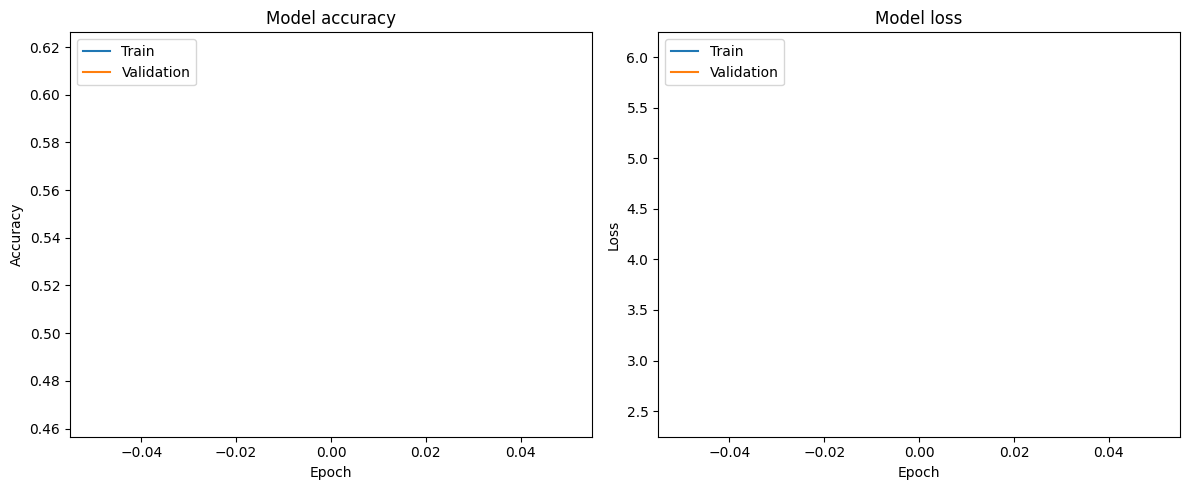

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.tight_layout()
plt.show()


In [20]:
predictions = model.predict(test_images)
predictions = (predictions > 0.5)

prediction_csv(test_labels, predictions, 'Basic CNN')

10/10 [==============================] - 1s 74ms/step
              precision    recall  f1-score     support
0              0.503425  1.000000  0.669704  147.000000
1              0.000000  0.000000  0.000000  145.000000
accuracy       0.503425  0.503425  0.503425    0.503425
macro avg      0.251712  0.500000  0.334852  292.000000
weighted avg   0.253436  0.503425  0.337145  292.000000
50.34246575342466
      Modell Accuracy Precision Recall F1-Score                       Date
0  Basic CNN      50%       25%    50%      33% 2024-04-27 00:45:55.603480


c:\Users\csang\miniconda3\envs\fhgr\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\csang\miniconda3\envs\fhgr\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\csang\miniconda3\envs\fhgr\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


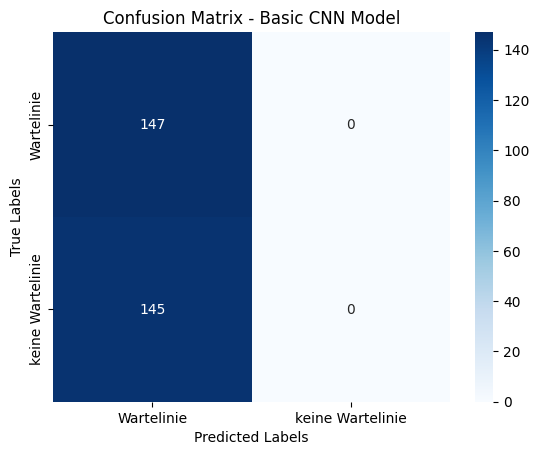

In [21]:
cm = confusion_matrix(test_labels, predictions)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=namelabels.values(), yticklabels=namelabels.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Basic CNN Model')
plt.show()